In [20]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob

import cartopy
import cartopy.crs as ccrs

import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
%matplotlib inline

In [21]:
#AEMET files
all_files = sorted(glob('/vg6/dargueso-NO-BKUP/OBS_DATA/AEMET_MED_hifreq/Arnau_*.txt'))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f, sep=';',header=0,encoding = "ISO-8859-1") for f in all_files)
prec_data   = pd.concat(df_from_each_file, ignore_index=True)
prec_data['dateInt']=prec_data['ANO'].astype(str) + prec_data['MES'].astype(str).str.zfill(2)+ prec_data['DIA'].astype(str).str.zfill(2)
prec_data['Date'] = pd.to_datetime(prec_data['dateInt'], format='%Y%m%d')
stn_info = prec_data.take(prec_data['INDICATIVO'].drop_duplicates().index)


In [22]:
stn_info["NLAT"] = 0
stn_info["NLON"] = 0
stn_info["sdate"] = 0
stn_info["edate"] = 0
nstn_info = stn_info[['INDICATIVO','NOMBRE','ALTITUD','NLON','NLAT','NOM_PROV','sdate','edate']]

In [23]:
for i, row in stn_info.iterrows():

    stn = row.INDICATIVO
    
    lon_str = f'{row.LONGITUD:07}'
    lat_str = f'{row.LATITUD:06}'
    
    if int(lon_str[-1])==1:
        new_lon = float(lon_str[:2])+float(lon_str[2:4])/60.+float(lon_str[4:6])/3600.
    elif int(lon_str[-1])==2:
        new_lon = -(float(lon_str[:2])+float(lon_str[2:4])/60.+float(lon_str[4:6])/3600.)

    new_lat = float(lat_str[:2])+float(lat_str[2:4])/60.+float(lat_str[4:6])/3600.
    
    nstn_info.at[nstn_info.INDICATIVO==stn,'NLON'] = round(new_lon,3)
    nstn_info.at[nstn_info.INDICATIVO==stn,'NLAT'] = round(new_lat,3)
    nstn_info.at[nstn_info.INDICATIVO==stn,'sdate']= prec_data[prec_data.INDICATIVO==stn].Date.min()
    nstn_info.at[nstn_info.INDICATIVO==stn,'edate'] = prec_data[prec_data.INDICATIVO==stn].Date.max()


/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


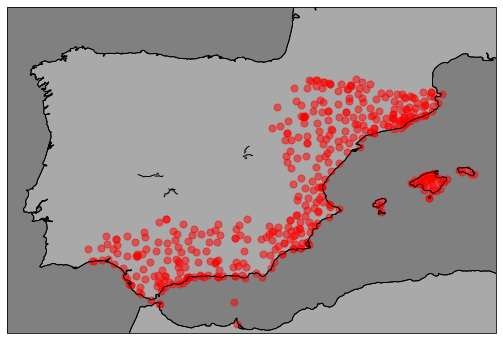

In [24]:
#Draw simple map
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.coastlines('10m',linewidth=0.8)
ax.add_feature(cfeature.OCEAN,facecolor='gray')
ax.add_feature(cfeature.LAND, edgecolor='k',facecolor='darkgray')
ax.add_feature(cfeature.LAKES,linewidth=0.5,edgecolor='k',facecolor='gray')

ax.set_extent([-10, 5, 35, 45],
              crs=ccrs.PlateCarree()) ## Important

plt.scatter(x=nstn_info.NLON, y=nstn_info.NLAT,
            c='r',
            edgecolor='face',
            s=50,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important


In [25]:
nstn_info = nstn_info.reset_index(drop=True)

In [26]:
nstn_info.to_csv('./AEMET_hifreq_station_info.csv')